In [ ]:
!pip install monai

In [ ]:
!pip install -q tensorboard-plugin-3d

In [ ]:
import torch
import nibabel as nib
import random
from nibabel.orientations import aff2axcodes
import pandas as pd
import monai
from monai.utils import first, set_determinism
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandSpatialCropd,
    RandCropByPosNegLabeld,
    NormalizeIntensityd,
    SaveImaged,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandGaussianNoised,
    ScaleIntensityRanged,
    RandAdjustContrastd,
    RandGaussianNoised,
    Spacingd,
    Invertd,
    MedianSmoothd,
    Resized,
    RandAffined,
    RandFlipd,
    Affined,
    Affine,
    RandAffine
)
import os
import shutil
import numpy as np
from google.colab import drive
import glob
import matplotlib.pyplot as plt
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, FlexibleUNet, EfficientNet, AttentionUnet, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, GeneralizedDiceLoss, DiceFocalLoss
from monai.inferers import sliding_window_inference
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from torch.utils.tensorboard import SummaryWriter

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Data = "/content/drive/MyDrive/EpiFat/Data"
root_dir = "/content/drive/MyDrive/EpiFat"
Label = "/content/drive/MyDrive/EpiFat/label"
Test_data_folder = "/content/drive/MyDrive/EpiFat/Test_data"
Test_labels_folder = "/content/drive/MyDrive/EpiFat/Test_label"

test_d = sorted(glob.glob(os.path.join(Test_data_folder, '*.nii')))
test_l = sorted(glob.glob(os.path.join(Test_labels_folder, '*.nii')))

train = sorted(glob.glob(os.path.join(Data, '*.nii')))
labels = sorted(glob.glob(os.path.join(Label, '*.nii')))

data_dicts= [{'image': image_name, 'label': label_name} for image_name, label_name in zip (train, labels)]
test_files= [{'image': image_name, 'label': label_name} for image_name, label_name in zip (test_d, test_l)]

train_files, val_files = data_dicts[:-20], data_dicts[-20:]
print(val_files)

# Test_labels = []
# for item in Test_data:
#   base_name = os.path.basename(item)
#   full_name = Label + '/' + base_name
#   Test_labels.append(full_name)

# train_data = [item for item in train if item not in Test_data]
# train_labels = [item for item in labels if item not in Test_labels]

[{'image': '/content/drive/MyDrive/EpiFat/Data/1389219.nii', 'label': '/content/drive/MyDrive/EpiFat/label/1389219.nii'}, {'image': '/content/drive/MyDrive/EpiFat/Data/1389909.nii', 'label': '/content/drive/MyDrive/EpiFat/label/1389909.nii'}, {'image': '/content/drive/MyDrive/EpiFat/Data/142256.nii', 'label': '/content/drive/MyDrive/EpiFat/label/142256.nii'}, {'image': '/content/drive/MyDrive/EpiFat/Data/177180.nii', 'label': '/content/drive/MyDrive/EpiFat/label/177180.nii'}, {'image': '/content/drive/MyDrive/EpiFat/Data/180106.nii', 'label': '/content/drive/MyDrive/EpiFat/label/180106.nii'}, {'image': '/content/drive/MyDrive/EpiFat/Data/183851.nii', 'label': '/content/drive/MyDrive/EpiFat/label/183851.nii'}, {'image': '/content/drive/MyDrive/EpiFat/Data/187312.nii', 'label': '/content/drive/MyDrive/EpiFat/label/187312.nii'}, {'image': '/content/drive/MyDrive/EpiFat/Data/246074.nii', 'label': '/content/drive/MyDrive/EpiFat/label/246074.nii'}, {'image': '/content/drive/MyDrive/EpiFat/Da

In [ ]:
set_determinism(seed=123)

In [ ]:
# Dataframe of pantient code and voxel sizes in data and masks

df = pd.DataFrame(columns=['FileName', 'height', 'width', 'slice thickness'])

filenames = []
dimensions = []

for filepath in train:
  base_name = os.path.basename(filepath)
  file_name_without_extension, _ = os.path.splitext(base_name)
  filenames.append(file_name_without_extension)

  nii = nib.load(filepath)
  header = nii.header
  voxel_dimensions = header.get_zooms()
  dimensions.append(voxel_dimensions)

data = {'filename': filenames,
        'height': [tup[0] for tup in dimensions],
        'width': [tup[1] for tup in dimensions],
        'slice thickness': [tup[2] for tup in dimensions]}
df = pd.DataFrame(data)
print(df)


df1 = pd.DataFrame(columns=['FileName', 'height', 'width', 'slice thickness'])

filenames1 = []
dimensions1 = []

for filepath in labels:
  base_name = os.path.basename(filepath)
  file_name_without_extension, _ = os.path.splitext(base_name)
  filenames1.append(file_name_without_extension)

  nii = nib.load(filepath)
  header = nii.header
  voxel_dimensions = header.get_zooms()
  dimensions1.append(voxel_dimensions)

data1 = {'filename': filenames1,
        'height': [tup[0] for tup in dimensions1],
        'width': [tup[1] for tup in dimensions1],
        'slice thickness': [tup[2] for tup in dimensions1]}
df1 = pd.DataFrame(data1)
df_train = df.iloc[:-20]
df_valid = df.iloc[-20:]
print(df_valid)

   filename    height     width  slice thickness
0   1027209  0.289062  0.289062              0.7
1   1047958  0.316406  0.316406              0.7
2   1098259  0.281250  0.281250              0.7
3   1103557  0.291016  0.291016              0.7
4   1128873  0.271484  0.271484              0.7
..      ...       ...       ...              ...
75   784767  0.316406  0.316406              0.7
76   799984  0.257812  0.257812              1.0
77   830487  0.312500  0.312500              0.7
78   841945  0.287109  0.287109              0.7
79   920723  0.285156  0.285156              1.0

[80 rows x 4 columns]
   filename    height     width  slice thickness
60  1389219  0.316406  0.316406              0.7
61  1389909  0.281250  0.281250              0.7
62   142256  0.392578  0.392578              0.7
63   177180  0.271484  0.271484              0.7
64   180106  0.306641  0.306641              0.7
65   183851  0.300781  0.300781              0.7
66   187312  0.316406  0.316406              0

In [ ]:
orientations_train =[]
orientations_label =[]

for filepath in train:
  # Load the NIfTI file
  nifti_file = nib.load(filepath)

  # Get the affine matrix
  affine_matrix = nifti_file.affine

  # Use aff2axcodes to get the orientation codes
  orientation_codes = aff2axcodes(affine_matrix)

  # Append to list
  orientations_train.append(orientation_codes)

for filepath in labels:
  # Load the NIfTI file
  nifti_file = nib.load(filepath)

  # Get the affine matrix
  affine_matrix = nifti_file.affine

  # Use aff2axcodes to get the orientation codes
  orientation_codes = aff2axcodes(affine_matrix)

  # Append to list
  orientations_label.append(orientation_codes)


print(orientations_train)
print(orientations_label)

[('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S'), ('L', 'A', 'S

# **Transformations**

In [ ]:
train_transforms = Compose ([
    LoadImaged (keys = ['image', 'label']),
    EnsureChannelFirstd (keys =['image', 'label']),
    Orientationd(keys=["image", "label"], axcodes="LAS"),
    Resized(keys=["image", "label"], spatial_size= (512,512,128), mode=("bilinear", "nearest")),
    # MedianSmoothd(keys="image", radius=1),
    ScaleIntensityRanged(keys=["image"], a_min=-135, a_max=215, b_min=0, b_max=1, clip=True),
    RandAffined(keys=["image", "label"],
                shear_range=(0.5, 0.5, 0.5),
                padding_mode='zeros',
                prob=0.5,
                mode=("bilinear", "nearest")),
    # RandGaussianNoised(keys=["image"],
    #                    prob=0.1),
    # RandAdjustContrastd(keys=["image"], gamma = (1.5,2),
    #                    prob=0.1)
])

val_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LAS"),
        Resized(keys=["image", "label"], spatial_size= (512,512,128), mode=("bilinear", "nearest")),
        # MedianSmoothd(keys="image", radius=1),
        ScaleIntensityRanged(keys=["image"], a_min=-135, a_max=215, b_min=0, b_max=1, clip=True),
])

# **Check our transformations**

In [ ]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=1)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=1)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=1)

Loading dataset: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


image shape: torch.Size([1, 512, 512, 128]), label shape: torch.Size([1, 512, 512, 128])


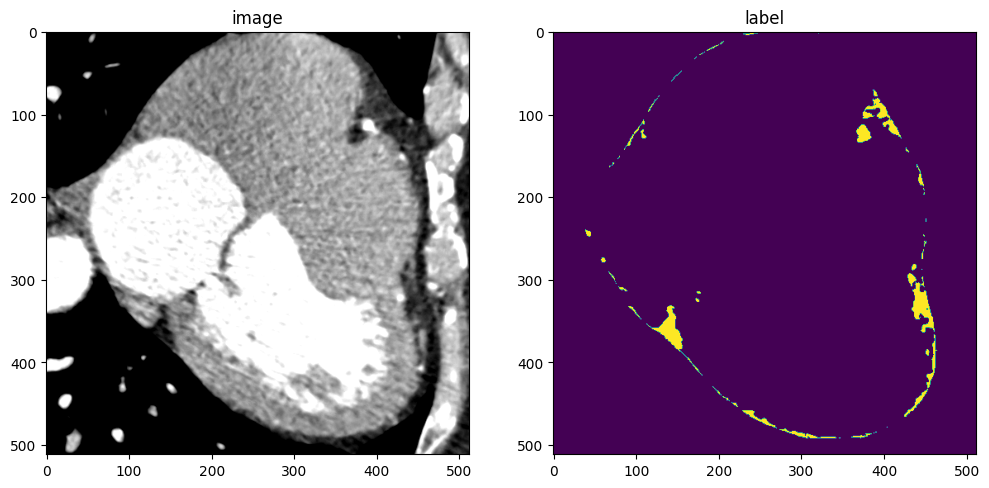

In [ ]:
image = val_ds[6]['image']
label = val_ds[6]['label']
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 50]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(val_ds[4]['image'][0,:, :, 60], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(val_ds[4]['label'][0,:, :, 60])
plt.show()

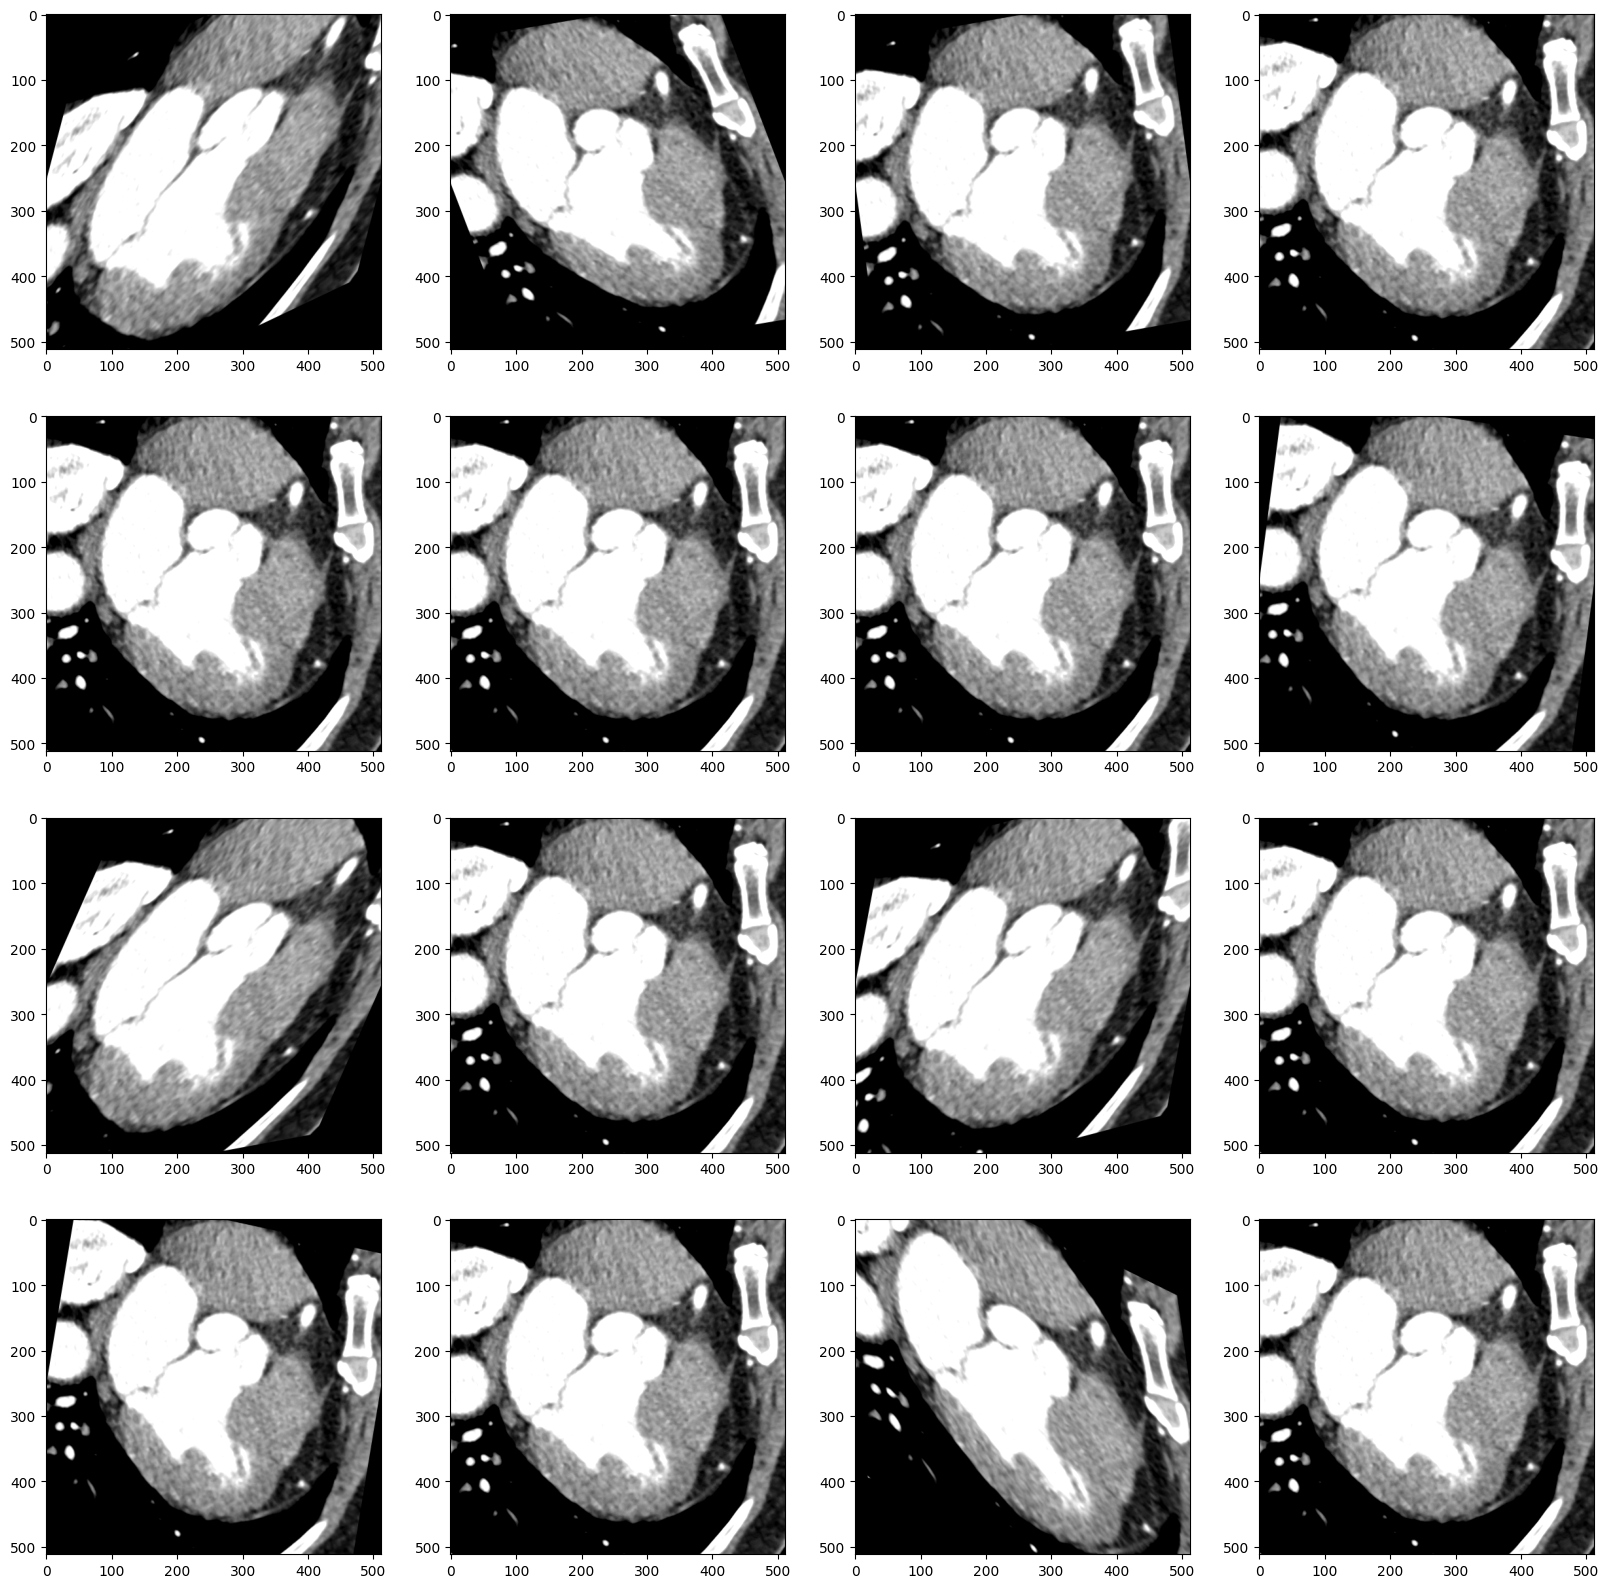

In [ ]:
fig, axes = plt.subplots (4,4, figsize=(20, 20))
axes = axes.flatten()
for i in range (16):
  img = train_ds[0]['image'].squeeze(0)
  axes[i].imshow(img[:,:,70], cmap='gray')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model1 = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH
).to(device)

# model2 = UNETR(in_channels=1, out_channels=1, img_size=(256,256,128), feature_size=32, norm_name='batch', spatial_dims=3).to(device)

# model3 = AttentionUnet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=1,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     kernel_size=3,
#     up_kernel_size=3,
#     dropout=0.2
# ).to(device)
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
model = model1
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, include_background=False)
optimizer = torch.optim.Adam(model.parameters(), 4e-3)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 100)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values_train = []
epoch_loss_values_val = []
metric_values = []


post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss_train = 0
    epoch_loss_val = 0
    dice_val = 0
    step = 0
    step_val = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss_train += loss.item()
        # print(f"{step}/{(len(train_ds) // train_loader.batch_size)+1}, " f"train_loss: {loss.item():.4f}")

    lr_scheduler.step()
    epoch_loss_train /= step
    epoch_loss_values_train.append(epoch_loss_train)
    print(f"epoch {epoch + 1} average train loss: {epoch_loss_train:.4f}")

    # if (epoch + 1) % val_interval == 0:
    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            step_val += 1
            val_inputs, val_labels = (
                val_data["image"].to(device),
                val_data["label"].to(device),
            )
            val_outputs = model(val_inputs)
            val_outputs_sigmoid = [post_trans(i) for i in decollate_batch(val_outputs)]

            loss_val = loss_function(val_outputs, val_labels)

            epoch_loss_val += loss_val.item()

            # print(f"{step_val}/{(len(val_ds) // val_loader.batch_size)}, " f"val_loss: {val_loss.item():.4f}")

            # compute metric for current iteration
            dice_metric(y_pred=val_outputs_sigmoid, y=val_labels)


        # aggregate the final mean dice result
        metric = dice_metric.aggregate().item()
        # reset the status for next validation round
        metric_values.append(metric)
        dice_metric.reset()

        epoch_loss_val /= step_val
        epoch_loss_values_val.append(epoch_loss_val)
        print(f"epoch {epoch + 1} average val loss: {epoch_loss_val:.4f}")


        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_Wmedian512512.pth"))
            print("saved new best metric model")
        print(
            f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            f"\nbest mean dice: {best_metric:.4f} "
            f"at epoch: {best_metric_epoch}"
        )

----------
epoch 1/100
epoch 1 average train loss: 0.8869
epoch 1 average val loss: 0.9155
saved new best metric model
current epoch: 1 current mean dice: 0.0866
best mean dice: 0.0866 at epoch: 1
----------
epoch 2/100
epoch 2 average train loss: 0.8440
epoch 2 average val loss: 0.9122
saved new best metric model
current epoch: 2 current mean dice: 0.0937
best mean dice: 0.0937 at epoch: 2
----------
epoch 3/100
epoch 3 average train loss: 0.8012
epoch 3 average val loss: 0.8610
saved new best metric model
current epoch: 3 current mean dice: 0.1633
best mean dice: 0.1633 at epoch: 3
----------
epoch 4/100
epoch 4 average train loss: 0.7304
epoch 4 average val loss: 0.7527
saved new best metric model
current epoch: 4 current mean dice: 0.3645
best mean dice: 0.3645 at epoch: 4
----------
epoch 5/100
epoch 5 average train loss: 0.6437
epoch 5 average val loss: 0.8375
current epoch: 5 current mean dice: 0.1754
best mean dice: 0.3645 at epoch: 4
----------
epoch 6/100
epoch 6 average trai

<ipython-input-35-f8e6e2d6dff6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth"))

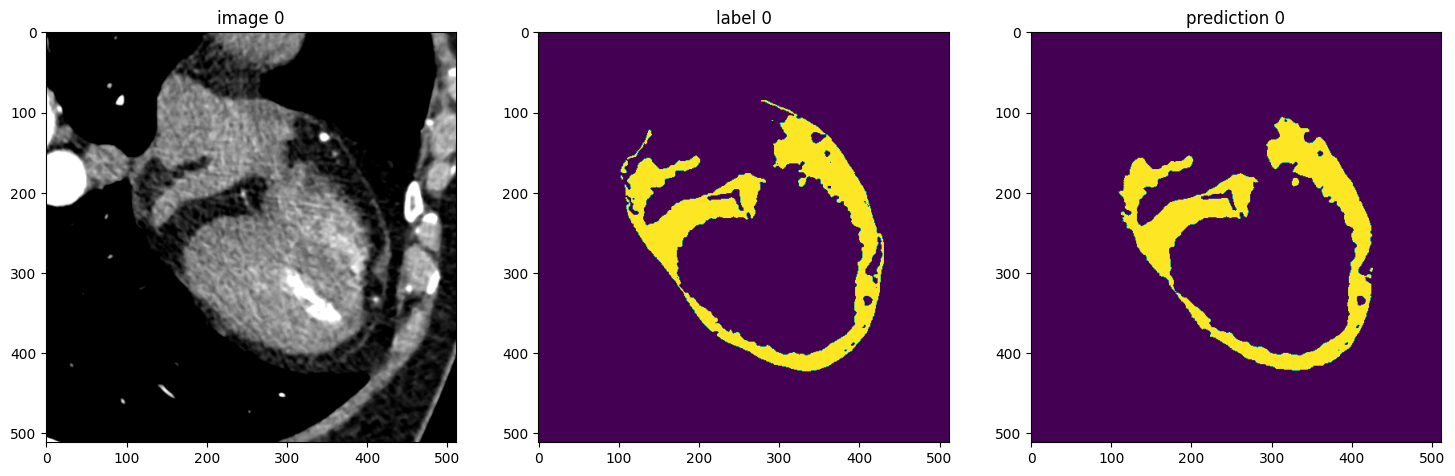

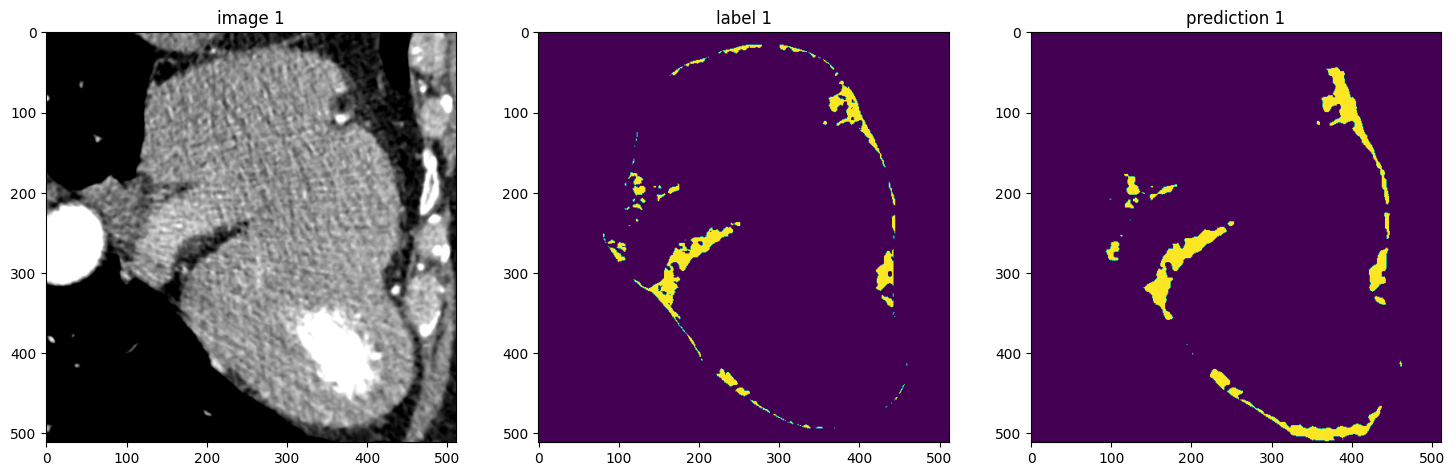

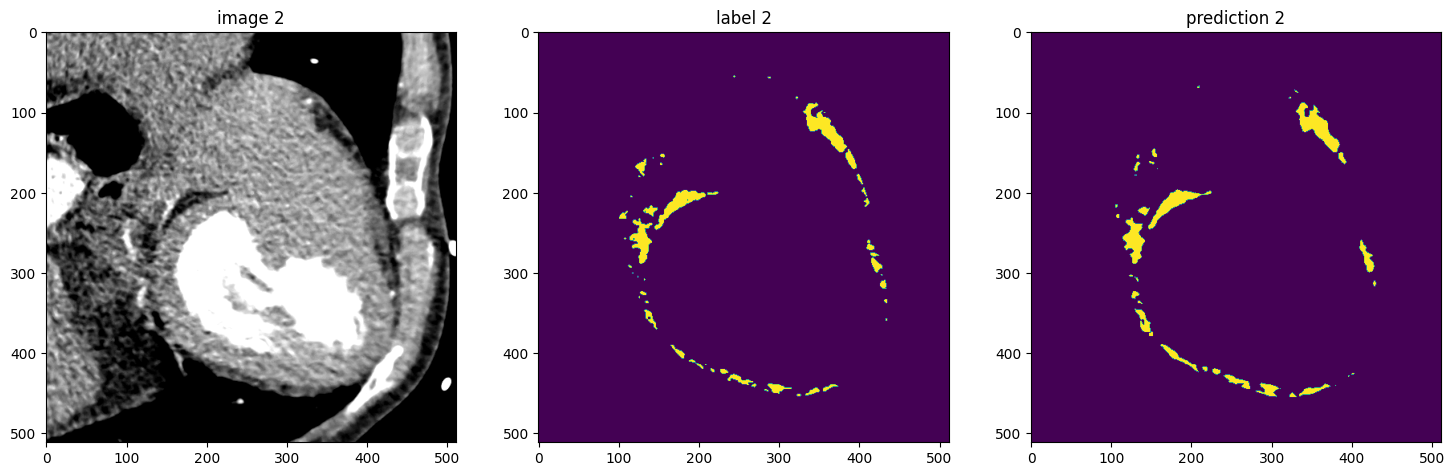

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        val_outputs = model(val_data["image"].to(device))
        # plot the slice [:, :, 40]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 40], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 40])
        plt.subplot(1, 3, 3)
        plt.title(f"prediction {i}")
        plt.imshow(post_trans(val_outputs).detach().cpu()[0, 0, :, :, 40])
        plt.show()
        if i == 2:
            break

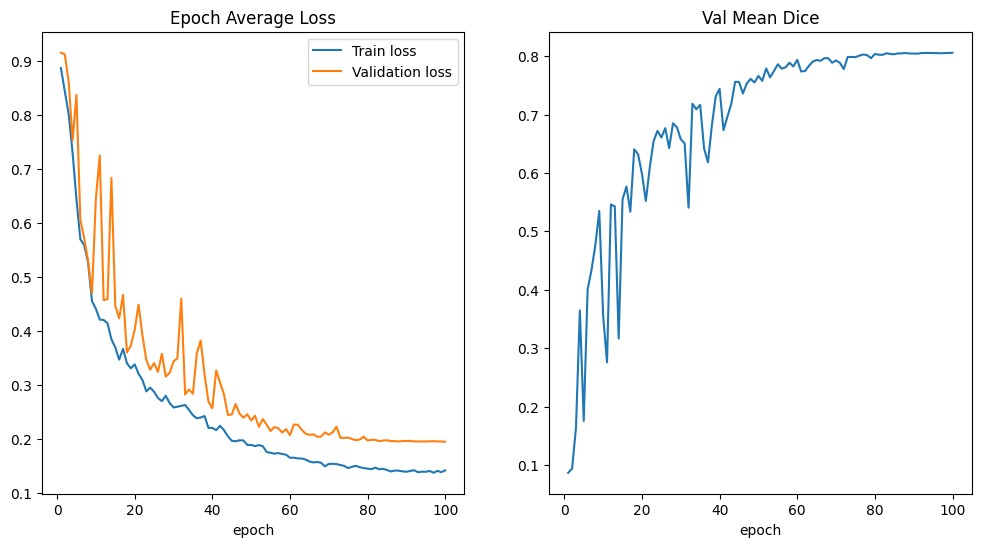

In [ ]:
plt.figure("train", (12, 6))

plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values_train))]
plt.xlabel("epoch")
plt.plot(x, epoch_loss_values_train, label='Train loss')
plt.plot(x, epoch_loss_values_val, label='Validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(x, metric_values)


plt.show()

# **Fat Volume Calculation, Inverting the transformations to get the original voxel spacings**

In [ ]:
val_org_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="LAS"),
        Resized(keys="image", spatial_size= (512,512,128), mode="bilinear"),
        MedianSmoothd(keys="image", radius=1),
        ScaleIntensityRanged(keys=["image"], a_min=-135, a_max=215, b_min=0, b_max=1, clip=True),
])

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [ ]:
val_org_ds = CacheDataset(data=val_files, transform=val_org_transforms, cache_rate=1.0, num_workers=1)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 20/20 [02:57<00:00,  8.85s/it]


In [ ]:
test_org_ds = CacheDataset(data=train_files, transform=val_org_transforms, cache_rate=1.0, num_workers=1)
test_org_loader = DataLoader(test_org_ds, batch_size=1, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 60/60 [15:30<00:00, 15.51s/it]


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth")))
model.eval()
with torch.no_grad():
  for test_data in test_org_loader:
      test_inputs, test_labels = (
          test_data["image"].to(device),
          test_data["label"].to(device),
      )
      test_outputs = model(test_inputs)
      test_outputs_sigmoid = [post_trans(i) for i in decollate_batch(test_outputs)]
      dice_metric(y_pred=test_outputs_sigmoid, y=test_labels)
  metric = dice_metric.aggregate().item()
print (metric)

<ipython-input-38-1371a2165c2c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth"))

0.8502371907234192


In [ ]:
filenames1 = []
dimensions1 = []

for filepath in test_d:
  base_name = os.path.basename(filepath)
  file_name_without_extension, _ = os.path.splitext(base_name)
  filenames1.append(file_name_without_extension)

  nii = nib.load(filepath)
  header = nii.header
  voxel_dimensions = header.get_zooms()
  dimensions1.append(voxel_dimensions)

data_test = {'filename': filenames1,
        'height': [tup[0] for tup in dimensions1],
        'width': [tup[1] for tup in dimensions1],
        'slice thickness': [tup[2] for tup in dimensions1]}
df_test = pd.DataFrame(data_test)

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth")))
model.eval()

mylist_test=[]
mylist_train=[]
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = model(test_inputs)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        mylist_train.append(test_data)


<ipython-input-24-3e4eb3be59a6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth"))

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth")))
model.eval()

volumes= []
filenamess= []
with torch.no_grad():
  for i, item in enumerate(mylist_train):
    name = df_train.iloc[i]['filename']
    x = int((item [0]['pred'] == 1).sum())
    y = df_train.iloc[i]['height'] * df_train.iloc[i]['width'] * df_train.iloc[i]['slice thickness']
    volume = x * y
    volumes.append(volume)
    filenamess.append(name)
Results_dict = {'filename': filenamess, 'volumes': volumes
}
results = pd.DataFrame(Results_dict)
print(results)
results.to_csv('/content/drive/MyDrive/EpiFat/train_preds.csv')

<ipython-input-25-632a4b919250>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth"))

   filename        volumes
0   1027209  144490.570065
1   1047958  194399.456259
2   1098259  127367.193999
3   1103557  131663.481690
4   1128873  182587.064121
5   1233717   89055.860710
6   1256850  150719.090798
7   1345533   51619.637260
8   1351176   99845.905800
9   1351410  145843.642294
10  1358608  160795.348111
11  1361797   83096.689909
12  1363810  108684.723053
13  1364825   79258.004344
14  1365664   92205.848694
15  1365775  155212.130941
16  1366010   98961.199740
17  1366325  241795.029609
18  1366678   94031.709344
19  1366895  121728.137984
20  1368136   70574.705079
21  1368349   75925.574128
22  1368660   73931.054265
23  1368779  209953.568391
24  1369601  194228.463411
25  1370857   83693.409329
26  1372423   79685.325714
27  1373370  100282.156906
28  1373494   90260.917402
29  1373816  130011.777267
30  1373845  144658.633953
31  1373899  159061.254681
32  1373904   79507.890042
33  1374084  158102.635956
34  1374327  144315.370770
35  1374444  114574.836969
3

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_512.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        sw = SummaryWriter(log_dir=root_dir)
        plot_2d_or_3d_image(data=val_outputs, step=0, writer=sw, frame_dim=-1, tag="image")
        plot_2d_or_3d_image(data=val_labels, step=0, writer=sw, frame_dim=-1, tag="label")

<ipython-input-62-90e3c456349c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model2.pth")))


In [ ]:
mylist[0][0]['pred'].unique(return_counts=True)

(metatensor([0., 1.]), metatensor([41068036,  2972156]))

In [ ]:
img = nib.load('/content/drive/MyDrive/EpiFat/label/246074.nii')
sx, sy, sz = img.header.get_zooms()
data = img.get_fdata()

# Count the number of 1s
num_ones = int((data == 1).sum())
num_zeros = int((data == 0).sum())

single_voxel_volume = sx * sy * sz
print(f"Number of 1s in the NIfTI file: {num_ones}")
print(f"Number of 0s in the NIfTI file: {num_zeros}")

Number of 1s in the NIfTI file: 3224588
Number of 0s in the NIfTI file: 40815604


In [ ]:
print(f"segmented epicardial fat volume is: {single_voxel_volume * num_ones}" + ' cc')
print(f"predicted epicardial fat volume is: {single_voxel_volume * (mylist[0][0]['pred'] == 1).sum()}" + ' cc')

segmented epicardial fat volume is: 183543.10262833536 cc
predicted epicardial fat volume is: 169174.70812873542 cc


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/EpiFat/New Data/pulmonary bifurcation not being visible.zip', 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/EpiFat/New Data")

In [ ]:
Unmanaged = "/content/drive/MyDrive/EpiFat/New Data/pulmonary bifurcation not being visible"
unmanaged = sorted(glob.glob(os.path.join(Unmanaged, '*.nii')))
unma_dicts= [{'image': image_name} for image_name in unmanaged]

filenames = []
dimensions = []

for filepath in unmanaged:
  base_name = os.path.basename(filepath)
  file_name_without_extension, _ = os.path.splitext(base_name)
  filenames.append(file_name_without_extension)

  nii = nib.load(filepath)
  header = nii.header
  voxel_dimensions = header.get_zooms()
  dimensions.append(voxel_dimensions)

data = {'filename': filenames,
        'height': [tup[0] for tup in dimensions],
        'width': [tup[1] for tup in dimensions],
        'slice thickness': [tup[2] for tup in dimensions]}
data_pd = pd.DataFrame(data)
print(data_pd)

   filename    height     width  slice thickness
0   1024960  0.291016  0.291016              0.7
1   1075740  0.289062  0.289062              0.7
2   1091611  0.267578  0.267578              0.7
3   1096870  0.273438  0.273438              0.7
4   1129326  0.316406  0.316406              0.7
..      ...       ...       ...              ...
92   726499  0.259766  0.259766              0.7
93   755653  0.242188  0.242188              0.7
94   813021  0.261719  0.261719              0.7
95   867466  0.265625  0.265625              0.7
96   979596  0.261719  0.261719              0.7

[97 rows x 4 columns]


In [ ]:
val_org_transforms = Compose([
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="LAS"),
        Resized(keys="image", spatial_size= (512,512,128), mode="bilinear"),
        MedianSmoothd(keys="image", radius=1),
        ScaleIntensityRanged(keys=["image"], a_min=-135, a_max=215, b_min=0, b_max=1, clip=True),
])

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [ ]:
unseen_ds = CacheDataset(data=unma_dicts, transform=val_org_transforms, cache_rate=1.0, num_workers=1)
unseen_loader = DataLoader(unseen_ds, batch_size=1, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 97/97 [12:42<00:00,  7.86s/it]


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth")))
model.eval()

mylist_test=[]
mylist_train=[]
with torch.no_grad():
    for test_data in unseen_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = model(test_inputs)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        mylist_train.append(test_data)

<ipython-input-28-932d3210735b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth"))

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth")))
model.eval()

volumes= []
filenamess= []
with torch.no_grad():
  for i, item in enumerate(mylist_train):
    name = data_pd.iloc[i]['filename']
    x = int((item [0]['pred'] == 1).sum())
    y = data_pd.iloc[i]['height'] * data_pd.iloc[i]['width'] * data_pd.iloc[i]['slice thickness']
    volume = x * y
    volumes.append(volume)
    filenamess.append(name)
Results_dict = {'filename': filenamess, 'volumes': volumes
}
results = pd.DataFrame(Results_dict)
print(results)
results.to_csv('/content/drive/MyDrive/EpiFat/New Data/pulmonary_bifur.csv')

<ipython-input-29-22b43f04dd98>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_Wmedian512.pth"))

   filename        volumes
0   1024960  156607.484051
1   1075740   95284.228687
2   1091611  107584.564530
3   1096870   57697.387848
4   1129326   97532.708669
..      ...            ...
92   726499   55296.937044
93   755653   44978.930113
94   813021  125003.137439
95   867466   32113.298067
96   979596   64778.053291

[97 rows x 2 columns]
